In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from dfHelper import*
import warnings
warnings.filterwarnings('ignore')

In [63]:
# we train a classsifier for each sensor

def data_split(sensor, split = 0.8):
    """
    prepare the data for each sensor classifier
    """
    subjects = [1,2,3]
    runs = [1,2,3,4,5]
    data = []
    targets = []
    lengths = []
    for subject in subjects:
        for run in runs:
            d = load_data_adl(subject, run, '../OpportunityUCIDataset')
            walk, lie =  get_locomotion_data(d, [2]), get_locomotion_data(d, [5])
            walk, lie = get_sensor_data(walk, sensor), get_sensor_data(lie, sensor)
            walk, lie = walk[walk.columns[:-8]], lie[lie.columns[:-8]]


            lie = lie.dropna()
            walk = walk.dropna()
            if len(lie)==0 or len(walk)==0:
                continue

            lengths.append(len(lie))
            lengths.append(len(walk))

            for c in lie.columns:
                data.append(lie[c].values)
                targets.append(-1)
            for c in walk.columns:
                data.append(walk[c].values)
                targets.append(1)
    #cut legth of data to the same length
    min_length = min(lengths)
    for i in range(len(data)):
        data[i] = data[i][:min_length]

    from sklearn.utils import shuffle
    data, targets = shuffle(data, targets)
    
    train_data = data[:int(len(data)*split)]
    test_data = data[int(len(data)*split):]
    train_targets = targets[:int(len(targets)*split)]
    test_targets = targets[int(len(targets)*split):]

    return train_data, test_data, train_targets, test_targets

In [89]:
train, test, train_targets, test_targets = data_split( "IMU_acc")

In [95]:
t = np.array(train)
t.reshape(t.shape[0], 1, t.shape[1])

array([[[1066.29170493, 1021.63692181, 1088.17783473, ...,
         1002.61956893,  999.50787891, 1002.22452574]],

       [[ 968.68415905, 1016.64546426, 1032.10706809, ...,
         1148.3070147 , 1214.86377837, 1024.49255732]],

       [[1036.15828907,  987.35252063,  960.87720339, ...,
          997.44373275,  997.7705147 , 1003.04436592]],

       ...,

       [[ 827.61826949,  937.8342071 , 1009.26656538, ...,
          570.95709121,  367.17026023,  481.5122013 ]],

       [[1073.1365244 , 1091.66569975, 1118.90705601, ...,
          897.34775868,  847.07496717,  851.47049274]],

       [[1015.49249136, 1052.96153776, 1043.46490118, ...,
          954.04087963,  913.26721172,  967.1194342 ]]])

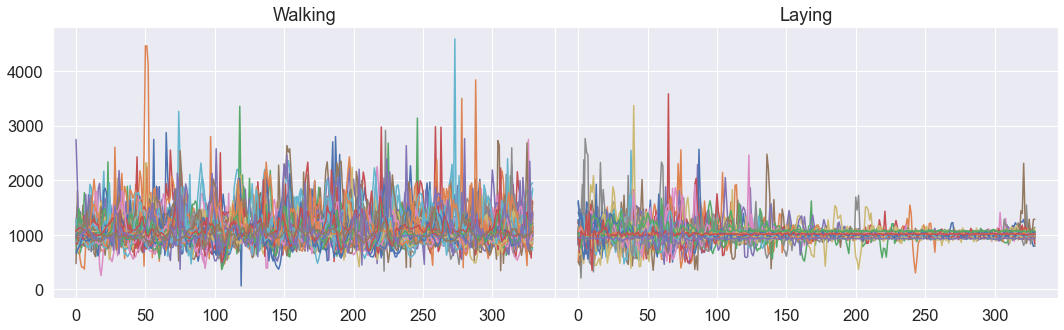

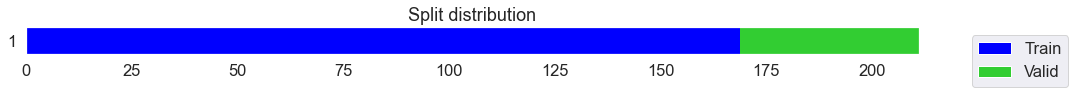

epoch,train_loss,valid_loss,accuracy,time
0,0.674716,0.674780,0.500000,00:00
1,0.670741,0.669792,0.500000,00:00
2,0.668436,0.660108,0.500000,00:00
3,0.666164,0.645425,0.500000,00:00
4,0.661388,0.626806,0.500000,00:00
5,0.654351,0.604256,0.523810,00:00
6,0.644880,0.581050,0.523810,00:00
7,0.632127,0.559918,0.595238,00:00
8,0.620606,0.537523,0.714286,00:00
9,0.603541,0.513047,0.785714,00:00


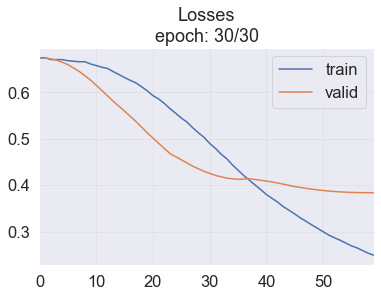

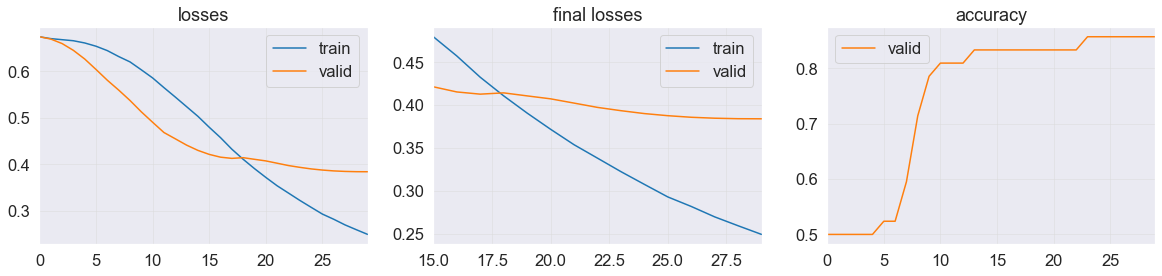

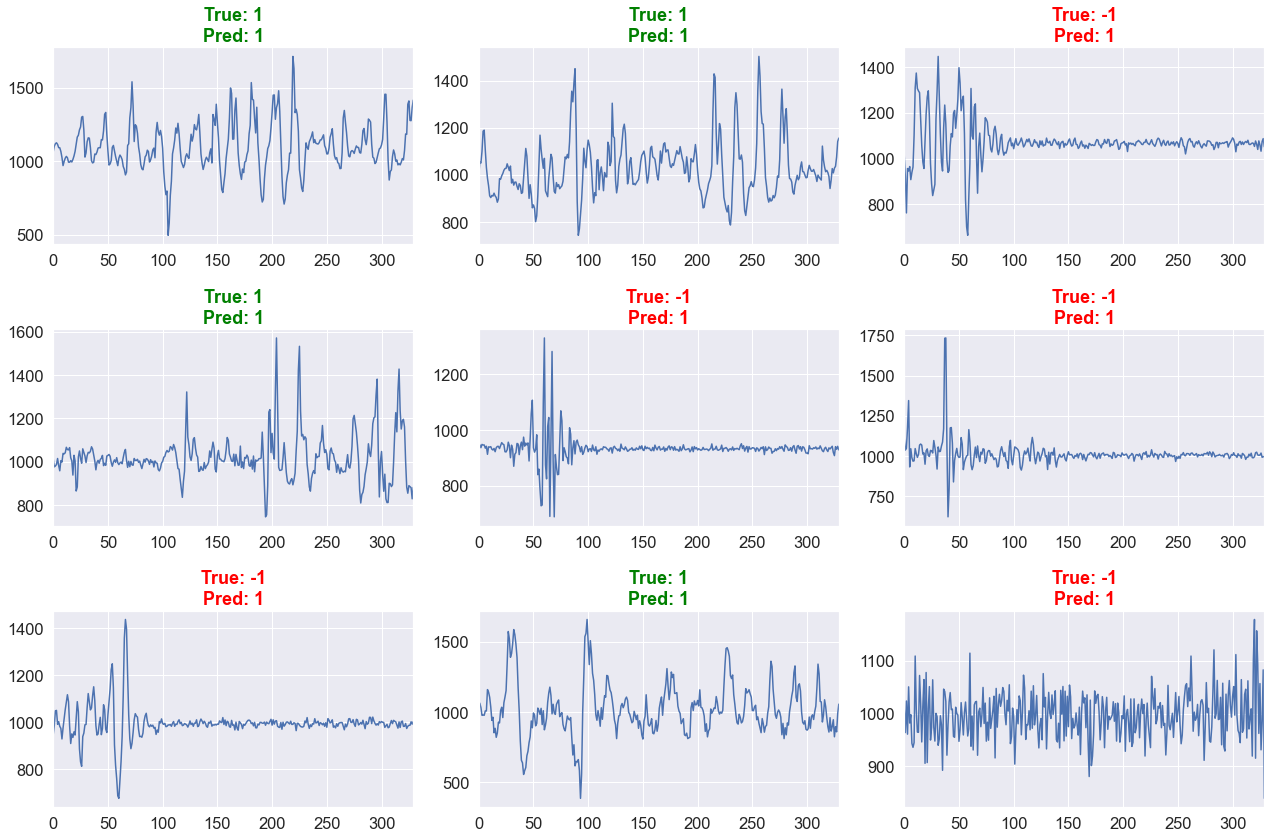

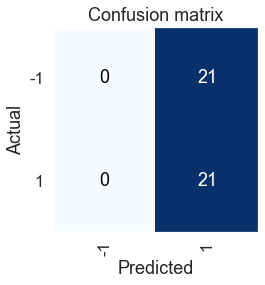

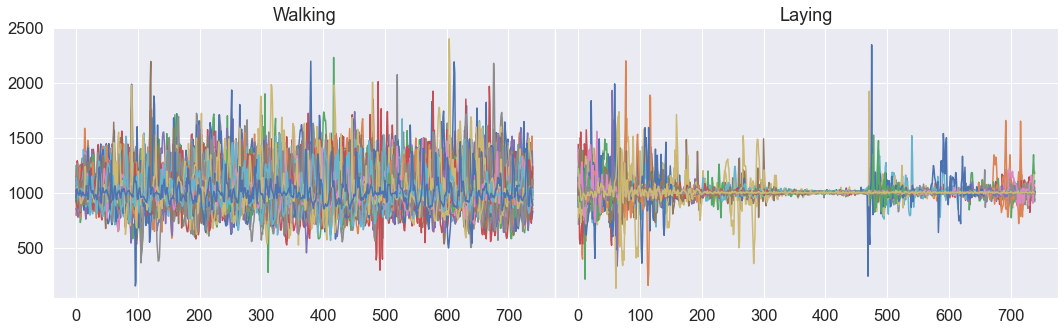

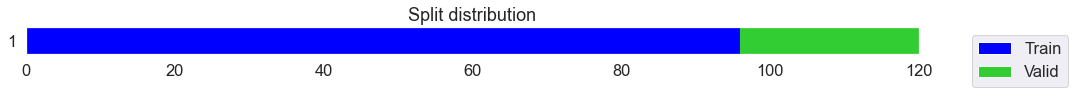

epoch,train_loss,valid_loss,accuracy,time
0,0.700748,0.695326,0.416667,00:00
1,0.697190,0.693225,0.458333,00:00
2,0.695328,0.688696,0.416667,00:00
3,0.688843,0.681266,0.416667,00:00
4,0.684318,0.671560,0.416667,00:00
5,0.678998,0.660037,0.416667,00:00
6,0.669151,0.646869,0.416667,00:00
7,0.658806,0.633306,0.416667,00:00
8,0.648392,0.620459,0.416667,00:00
9,0.634631,0.607846,0.416667,00:00


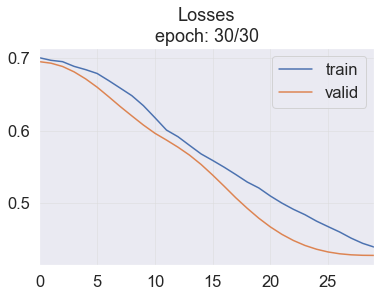

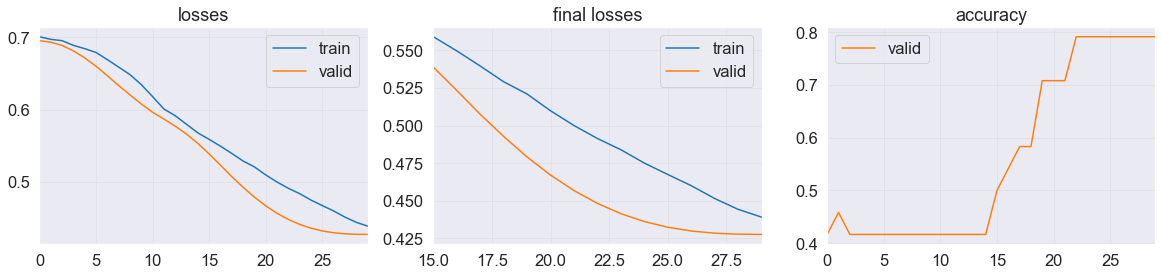

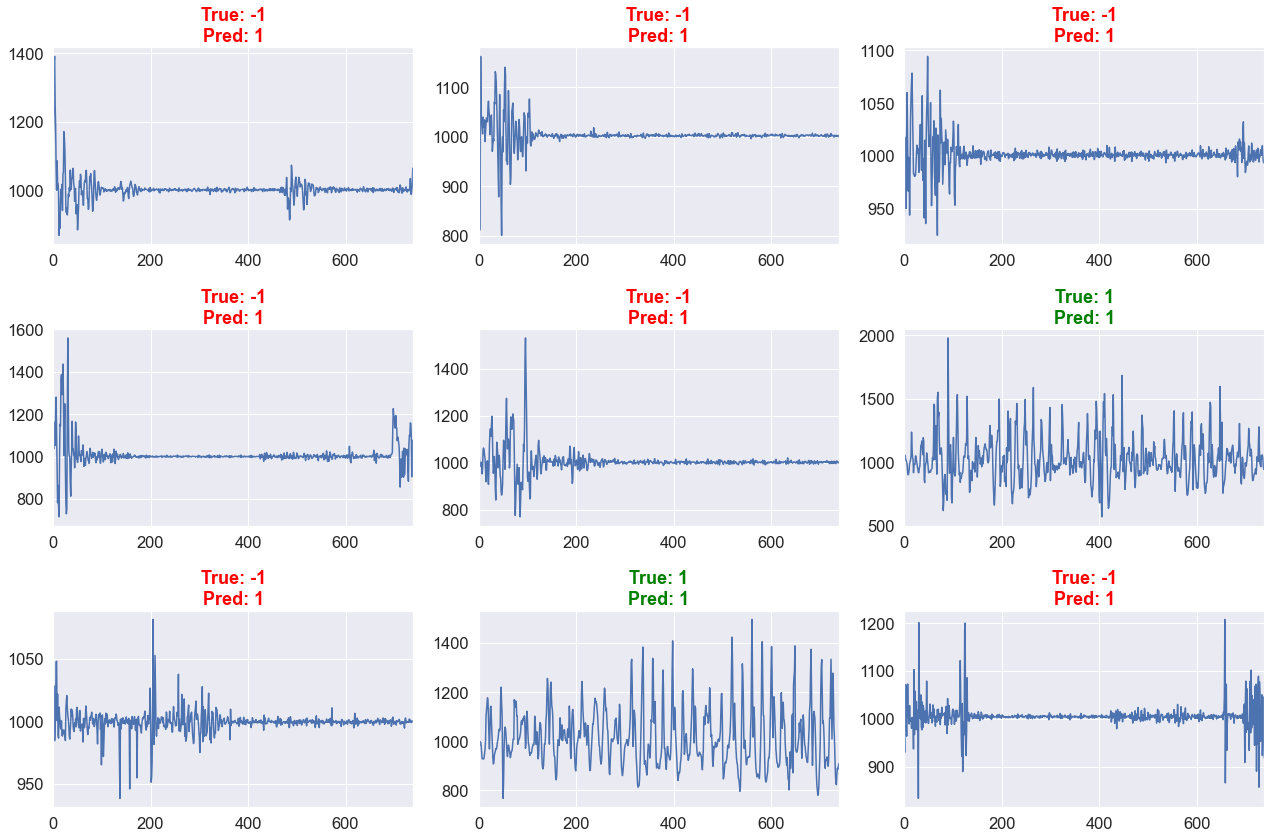

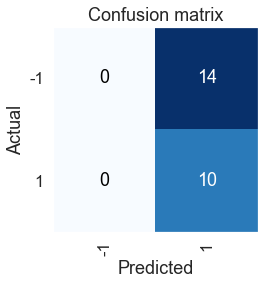

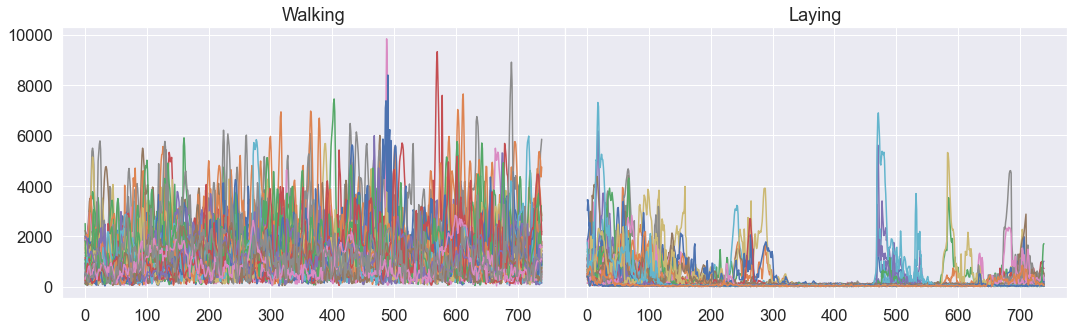

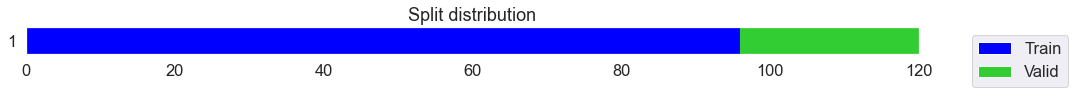

epoch,train_loss,valid_loss,accuracy,time
0,0.690962,0.687450,0.625000,00:00
1,0.691789,0.672491,0.666667,00:00
2,0.684742,0.645949,1.000000,00:00
3,0.677766,0.618333,1.000000,00:00
4,0.668135,0.593256,1.000000,00:00
5,0.658214,0.574170,1.000000,00:00
6,0.647513,0.562805,1.000000,00:00
7,0.638027,0.559219,1.000000,00:00


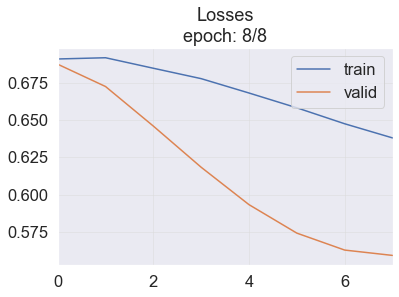

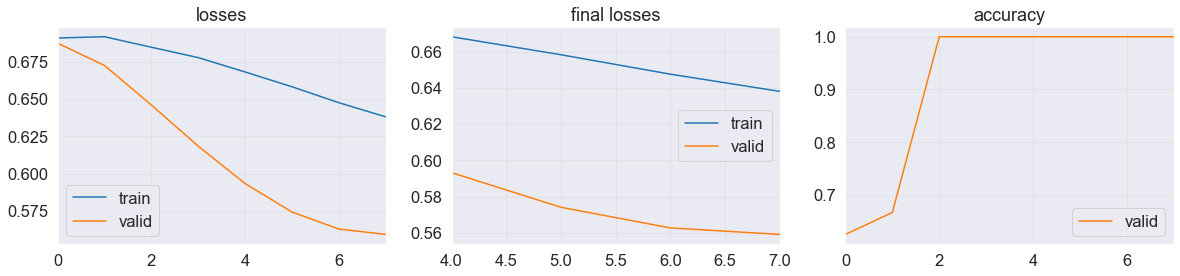

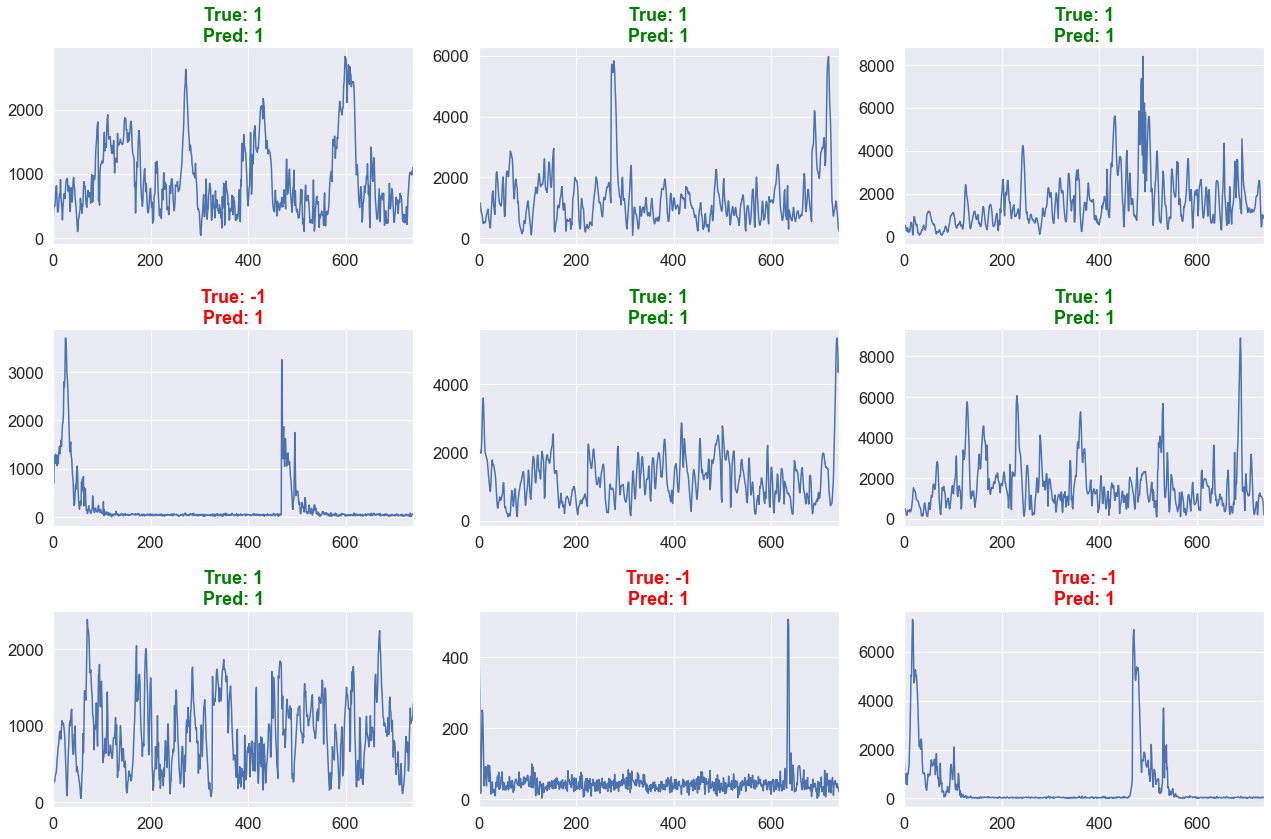

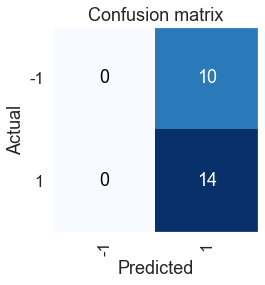

In [84]:
sensors = ["triaxial_acc"]#, "IMU_acc", "IMU_gyro"]
epochs = [30]#, 30, 8]
lrs = [3*1e-4]#, 3*1e-4, 1e-4]

from tsai.all import *

def train_model (X, y, filename, epochs, lr):

    batch_tfms = TSStandardize()
    if not os.path.isdir('models'): 
        os.mkdir('models')
    clf = TSClassifier(X, y,  path='models', batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph(), arch=MLP)
    clf.fit_one_cycle(epochs, lr)
    clf.export(filename+".pkl")
    clf.show_results()
    interp = ClassificationInterpretation.from_learner(clf)
    interp.plot_confusion_matrix()


for s,e,lr in zip(sensors, epochs, lrs):
    # data preparation
    
    train_data, test_data, train_targets, test_targets = data_split(s)ù
    
    #plot 
    fig, ax = plt.subplots(1,2, figsize=(18,5))
    sns.set_theme(style='darkgrid', palette='deep', font_scale=1.5)
    for X, y in zip(train_data, train_targets):
        if y == 1:
            sns.lineplot(x=range(len(X)), y=X, label=y, ax=ax[0])
        else:
            sns.lineplot(x=range(len(X)), y=X, label=y, ax=ax[1])
    ax[0].legend().remove()
    ax[1].legend().remove()
    ax[1].set_ylim(ax[0].get_ylim())
    fig.subplots_adjust(hspace=.0, wspace=0.)
    ax[1].set_yticklabels([])
    ax[0].set_title('Walking')
    ax[1].set_title('Laying')

    import os
    if not os.path.exists('figures'):
        os.mkdir('figures')
    fig.savefig('figures/'+s+'_signals_walk_lie.png')

    #train classifier
    train_model (train_data,train_targets, str(s), e, lr)


In [119]:
def data_centers(sensor, nclusters, metric='euclidean'):

    X, y = list(), list()
     
    subjects = [1,2,3]
    runs = [1,2,3, 4]
    length = []
    for s in subjects:
        for r in runs:
            data_laying = pd.read_csv('clustering_results_{}/subject_{}/run_{}/laying/sensor_type_{}/{}_clusters.csv'.format(metric, s, r, sensor, nclusters))
            data_walking = pd.read_csv('clustering_results_{}/subject_{}/run_{}/walking/sensor_type_{}/{}_clusters.csv'.format(metric, s, r, sensor, nclusters))
            for i in range(nclusters):
                series = data_laying['center {}'.format(i)]
                if len(series)>0:
                    X.append(series.values)
                    y.append(-1)
                    length.append(len(series))
                
                series = data_walking['centers {}'.format(i)]
                if len(series)>0:
                    X.append(series.values)
                    y.append(1)
                    length.append(len(series))
    #same length
    min_length = min(length)
    for i in range(len(X)):
        X[i] = X[i][:min_length]

    from sklearn.utils import shuffle
    X, y = shuffle(X, y)
    return X, y
        

In [123]:
c = 2
sensors = ["triaxial_acc", "IMU_acc", "IMU_gyro"]

X, y = data_centers(sensors[0], c)

In [126]:
xx = np.array(X)
xx.shape
xx = xx.reshape(xx.shape[0], 1, xx.shape[1])
xx.shape

(42, 1, 330)

In [127]:
def accuracy (model, X, y):


    X = np.array(X)
    X = X.reshape(X.shape[0], 1, X.shape[1])
    y = np.array(y)

    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)


    learn = load_learner(model)

    test_probas, test_targets, test_preds = learn.get_X_preds(dls, with_decoded=True)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y, test_preds)

acc = accuracy('models/'+sensors[0]+'.pkl', X, y)



AttributeError: ndim